In [1]:
#from v4_RGF_BBG.py import test_Gk_single
from FastRGF.solveRGF import MOMfastrecDOSfull
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
# from scipy.linalg import norm
from scipy.integrate import simpson, quad
from functools import partial

%load_ext autoreload
%autoreload 2

### Import of functions from file without dask

In [2]:
epsA1 = 0 
deltaprime = 0.022
epsA2 = deltaprime
epsB1 = deltaprime
epsB2 = 0
gamma0 = 3.16
gamma1 = 0.381
gamma3 = 0.38
gamma4 = 0.14



def ret_H0(kx):
	Tx = np.zeros((8,8),dtype=np.cdouble)
	Tx[0,5] = -gamma3
	Tx[0,6] = -gamma0
	Tx[0,7] = gamma4
	Tx[2,5] = gamma4
	Tx[3,5] = -gamma0
	Tx = Tx * np.exp(-1j*kx)
	#P = Tx + Tx.conj().T

	#Horrible code ahead : please don't judge

	M = np.zeros((8,8),dtype=np.cdouble)
	M[0,0] = epsB2
	M[0,1] = -gamma3
	M[0,2] = -gamma0
	M[0,3] = gamma1
	M[1,1] = epsA1
	M[1,2] = gamma4
	M[1,3] = -gamma0
	M[1,4] = -gamma3
	M[1,6] = gamma4
	M[1,7] = -gamma0
	M[2,2] = epsA2
	M[2,3] = gamma1
	M[2,4] = -gamma0
	M[3,3] = epsB1
	M[3,4] = gamma4
	M[4,4] = epsB2
	M[4,5] = -gamma3
	M[4,6] = -gamma0
	M[4,7] = gamma4
	M[5,5] = epsA1
	M[5,6] = gamma4
	M[5,7] = -gamma0
	M[6,6] = epsA2
	M[6,7] = gamma1
	M[7,7] = epsB1
	M = M + Tx
	M = M + M.conj().T - np.diag(np.diag(M))

	return M 


def ret_Ty(kx):
	# non-hermitian : only couples along -ve y direction
	Ty = np.zeros((8,8),dtype = np.cdouble)
	Ty[0,2] = -gamma0
	Ty[0,3] = gamma4
	Ty[0,5] = -gamma3 * np.exp(-1j*kx)
	Ty[1,2] = gamma4
	Ty[1,3] = -gamma0
	Ty[1,4] = -gamma3
	Ty[6,4] = -gamma0
	Ty[6,5] = gamma4
	Ty[7,4] = gamma4
	Ty[7,5] = -gamma0

	return Ty


def generate_grid_with_peaks(a, b, peaks, peak_spacing=0.01, num_pp = 200, num_uniform=1000):
    # Sort the peaks list
    assert a < b , "a should be less than b" 
    peaks = sorted(peaks)
    
    # Generate grid around peaks
    peak_grid = np.concatenate([np.linspace(max(a, peak - peak_spacing), min(b, peak + peak_spacing), num = num_pp, dtype=np.double)
                                for peak in peaks])

    # Generate uniform grid for the remaining region
    # uniform_grid = np.linspace(max(a, min(peaks, default=a) + peak_spacing),
    #                            min(b, max(peaks, default=b) - peak_spacing), num=int((b - a) / uniform_spacing))
    uniform_grid = np.linspace(a,b,num=num_uniform,dtype=np.double)

    # Concatenate the peak and uniform grids
    grid = np.sort(np.concatenate([peak_grid, uniform_grid]))

    return grid


def test_Ginfkx():
	# omega = 1 - 1e-2
	omega = 2e-3 
	# omega = 0.000444967
	# omega = 0.000740532
	# omega = 2e-2
	omegavals = (omega,)
	# kxvals = np.linspace(-np.pi,np.pi,10000,dtype=np.double)
	kxvals = np.linspace(-0.2,0.2,1000,dtype=np.double)
	# delta = min(1e-4,0.01*omega)
	# delta = 1e-4 if omega>1e-3 else 1e-6
	delta = 1e-6
	# delta = 0.01*omega
	RECURSIONS = 30
	dimH = 8
	num_pp = 2000
	start_time = time.perf_counter()
	kDOS = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)
					for omega in omegavals for kx in kxvals],dtype=np.longdouble).reshape((len(omegavals),len(kxvals),dimH,dimH))
	# peaks = find_peaks(kDOS[0,:,0,0],prominence=0.01*np.max(kDOS[0,:,0,0]))[0]
	peaks = find_peaks(kDOS[0,:,0,0],prominence=0.1)[0]
	print(f'Peaks found on sparse grid : {len(peaks)}')
	peakvals = [kxvals[peak] for peak in peaks]
	print("creating fine grid")
	adaptive_kxgrid = generate_grid_with_peaks(-np.pi,np.pi,peakvals,peak_spacing=0.01,num_uniform=1000,num_pp=num_pp)
	fine_integrand = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)[0,0] for kx in adaptive_kxgrid],dtype=np.double)

	print('finding additional peaks')
	# new_peaks = find_peaks(fine_integrand,prominence=0.01*np.max(fine_integrand))[0]
	new_peaks = find_peaks(fine_integrand,prominence=0.1)[0]
	new_peakvals = [adaptive_kxgrid[peak] for peak in new_peaks]
	new_peakvals = sorted(new_peakvals)

	fig, ax = plt.subplots(1)
	ax.plot(kxvals, kDOS[0,:,0,0])
	ax.set_xlabel(r'$k_x$')
	ax.set_title(f'$\\omega$ = {omega:.3}, \\delta = {delta:.6}, RECURSIONS = {RECURSIONS}')
	# ax.vlines(kxvals[peaks], ls = '--', c = 'grey')
	for peak in new_peakvals:
		ax.axvline(peak,ls='--',c='gray')

	# ax.legend()
	# print('Started quad integrate without peaks')
	# start_time = time.perf_counter()
	# intval = quad(lambda kx : MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta,)[0,0], 
	# 					-np.pi,np.pi)[0]
	# elapsed = time.perf_counter() - start_time
	# print(f'Finished quad integrator with delta = {delta:.6} and {RECURSIONS} recursions in {elapsed} sec(s).')
	# print(f'intval = {intval:.5}')

	print(f'Total number of peaks found = {len(new_peakvals)}')

	# print('Started quad integrate WITH peaks')
	# start_time = time.perf_counter()
	# call_int = lambda kx : MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)[0,0]

	# start,stop = -np.pi,np.pi
	# ranges = []
	# eta = 0.5*delta
	# # eta = 1e-3
	# current = start
	# for peak in new_peakvals:
	# 	ranges += [(current, peak-eta)]
	# 	current = peak+eta
	# ranges += [(current, stop)]		
	# intlist = [quad(call_int,window[0],window[1],limit=500,epsabs=0.1*delta)[0] for window in ranges]
	# for word in list(zip(ranges,intlist)):
	# 	print(word)
	# intval = np.sum(intlist)

	# # intval = quad(call_int, -np.pi,np.pi, points = [kxvals[peak] for peak in peaks])[0]
	# elapsed = time.perf_counter() - start_time
	# print(f'Finished quad integrator with delta = {delta:.6} and {RECURSIONS} recursions in {elapsed} sec(s).')
	# print(f'intval = {intval:.5}')

	# print('STARTED SIMPSON INTEGRATION')
	# start_time = time.perf_counter()
	# simpson_intval = simpson(fine_integrand,adaptive_kxgrid)
	# elapsed = time.perf_counter() - start_time
	# print(f'Finished simpson integrator with delta = {delta:.6} and {RECURSIONS} recursions in {elapsed} sec(s).')
	# print(f'intval = {simpson_intval:.8}')



	# for num_pp in [2000]: #checking convergence
	# 	print('Started simpson integrate WITH peaks')
	# 	peak_spacing = 0.01
	# 	print(f'num_pp = {num_pp}, peak_spacing = {peak_spacing:.4}')
	# 	start_time = time.perf_counter()
	# 	adaptive_kxgrid = generate_grid_with_peaks(-np.pi,np.pi,new_peakvals,peak_spacing=0.1,num_uniform=10000,num_pp=num_pp)
	# 	fine_integrand = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)[0,0] for kx in adaptive_kxgrid],dtype=np.double)
	# 	simpson_intval = simpson(fine_integrand,adaptive_kxgrid)
	# 	elapsed = time.perf_counter() - start_time
	# 	print(f'Finished simpson integrator with delta = {delta:.6} and {RECURSIONS} recursions in {elapsed} sec(s).')
	# 	print(f'intval = {simpson_intval:.8}')
	# print(type(fine_integrand[0]))
	ax.plot(adaptive_kxgrid,fine_integrand,'.',c='red')
	plt.show()
	print(adaptive_kxgrid[fine_integrand<0])
    
    
def helper_LDOS_mp(omega):
    RECURSIONS = 20
    delta = 1e-4 #if omega>1e-3 else 1e-6
    num_pp = 1000
    call_int = lambda kx : MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)[1,1]
    
    kxgrid = np.linspace(-np.pi,np.pi,10000,dtype=np.double)
    # sparseLDOS = np.array([MOMfastrecDOSfull(omega,ret_H0(kx),ret_Ty(kx),RECURSIONS,delta)
    # 				for kx in kxvals],dtype=np.longdouble).reshape((len(kxvals),dimH,dimH))
    sparseLDOS = np.array([call_int(kx) for kx in kxgrid],dtype=np.double)
    peaks = find_peaks(sparseLDOS,prominence=0.01)[0]
    peakvals = [kxgrid[peak] for peak in peaks] #peakvals
    peakvals = sorted(peakvals)

    if len(peakvals) > 20:
        return float('NaN')

    adaptive_kxgrid = generate_grid_with_peaks(-np.pi,np.pi,peakvals,peak_spacing=0.01,num_uniform=10000,num_pp=num_pp)
    fine_integrand = np.array([call_int(kx) for kx in adaptive_kxgrid],dtype=np.double)
    new_peaks = find_peaks(fine_integrand,prominence=0.01)[0]
    new_peakvals = [adaptive_kxgrid[peak] for peak in new_peaks]
    new_peakvals = sorted(new_peakvals)

    if len(new_peakvals) > 25:
        return float('NaN')

    start,stop = -np.pi,np.pi
    ranges = []
    # eta = 0.5*delta
    eta = 0.5*delta
    current = start
    for peak in new_peakvals:
        ranges += [(current, peak-eta)]
        current = peak+eta
    ranges += [(current, stop)]    
    intlist = [quad(call_int,window[0],window[1],limit=500,epsabs=0.1*delta)[0] for window in ranges]
    LDOS = np.sum(intlist)
    print('done', omega)
    return LDOS


def test_LDOS_mp():
    '''
    Use scipy.quad for this
    '''
    #RECURSIONS = 25
    #delta = 1e-3
    omegavals = np.logspace(np.log10(1e-6), np.log10(0.5e0), num = 100)

    
    
    LDOS = [helper_LDOS_mp(wi) for wi in omegavals]
    print('delta 1e-4')
    print(omegavals)
    print(list(LDOS))
    
    #savedict = {'omegavals' : omegavals,
    #			'LDOS' : LDOS,
    #			'INFO' : '[0,0] site of -1/pi Im G, delta = 1e-4 if omega>1e-3 else 1e-6, RECURSIONS = 25'
    #			}
    fig,ax = plt.subplots(1)
    ax.plot(omegavals, LDOS, '.-', label = 'quad LDOS')
    ax.axvline(1., ls='--', c='grey')
    ax.set_xlabel('omega')
    # ax.set_title(f'Bilayer Graphene LDOS A site with $\\delta = $ {delta:.6}')
    plt.show()

### Test of DOS run on small scale set of omega

done 1e-06
done 7.196856730011514e-06
done 5.1794746792312125e-05
done 0.0003727593720314938
done 0.0026826957952797246
done 0.019306977288832496
done 0.1389495494373136
done 1.0


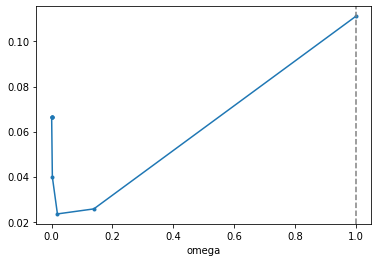

In [42]:
test_LDOS_mp()

done 1e-06
done 1.1417351024761893e-06
done 1.3035590442263117e-06
done 1.4883191189434913e-06
done 1.699266181784215e-06
done 1.9401118481937237e-06
done 2.21509379981273e-06
done 2.5290503465235533e-06
done 2.887505556555511e-06
done 3.2967664525144656e-06
done 3.7640339835016663e-06
done 4.297529725877133e-06
done 4.906640541968788e-06
done 5.602083741998559e-06
done 6.396095655250919e-06
done 7.302646928395401e-06
done 8.337688339138951e-06
done 9.51943145030134e-06
done 1.0868669042424836e-05
done 1.2409140962932705e-05
done 1.4167951828955421e-05
done 1.6176047933310132e-05
done 1.846876174479759e-05
done 2.1086433583304755e-05
done 2.4075121408091814e-05
done 2.7487411207994348e-05
done 3.138334225236458e-05
done 3.583146348254879e-05
done 4.091003963111959e-05
done 4.670842829054129e-05
done 5.3328652160802786e-05
done 6.088719413973122e-05
done 6.951704684061366e-05
done 7.937005259840992e-05
done 9.061957513698607e-05
done 0.00010346354990537542
done 0.000118127966753764
done

<ipython-input-2-4bd9d1969324>:230: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intlist = [quad(call_int,window[0],window[1],limit=500,epsabs=0.1*delta)[0] for window in ranges]


done 0.02707274082090774
done 0.030909898515470345
done 0.03529091614908914
done 0.040292877765958815
done 0.04600379292517755
done 0.05252414522972098
done 0.0599686603363296
done 0.06846832455445907
done 0.07817268955155815
done 0.08925250371598757
done 0.10190271647642953
done 0.11634590843881808
done 0.13283620769407928
done 0.15166376120414798
done 0.17315983994034181
done 0.1977026675990467
done 0.22572407545101308
done 0.2577171004164055
done 0.2942446600537911
done 0.33594945709958596
done 0.38356528782841587
done 0.43792995320508454
done 0.5
delta 1e-4
[1.00000000e-06 1.14173510e-06 1.30355904e-06 1.48831912e-06
 1.69926618e-06 1.94011185e-06 2.21509380e-06 2.52905035e-06
 2.88750556e-06 3.29676645e-06 3.76403398e-06 4.29752973e-06
 4.90664054e-06 5.60208374e-06 6.39609566e-06 7.30264693e-06
 8.33768834e-06 9.51943145e-06 1.08686690e-05 1.24091410e-05
 1.41679518e-05 1.61760479e-05 1.84687617e-05 2.10864336e-05
 2.40751214e-05 2.74874112e-05 3.13833423e-05 3.58314635e-05
 4.09

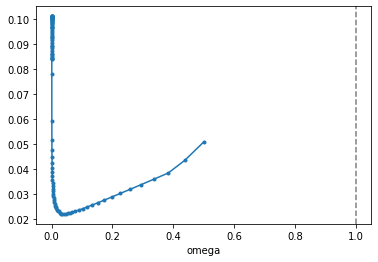

In [3]:
test_LDOS_mp()

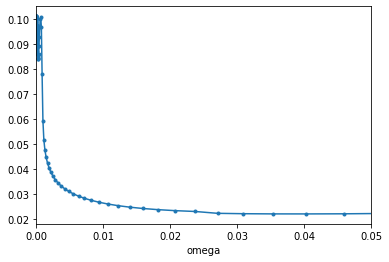

In [6]:
fig,ax = plt.subplots(1)
omegavals = np.logspace(np.log10(1e-6), np.log10(0.5e0), num = 100)
LDOS = [0.10126218221023715, 0.1012420482351275, 0.10121906081406416, 0.10119281407154798, 0.10116283334167327, 0.1011285648073382, 0.10108946517675192, 0.10104483469380261, 0.1009938866531878, 0.10093571151587903, 0.10086930258740306, 0.10079349391412044, 0.1007069308241414, 0.10060815001418398, 0.10049541009282015, 0.10036676322456652, 0.10022003188181325, 0.10005271605402384, 0.09986205339867253, 0.09964485483084796, 0.09939769221339174, 0.09911667643331594, 0.09879765089950907, 0.09843609654725272, 0.09802719525525996, 0.097566116536139, 0.09704789869923246, 0.09646804573683336, 0.09582260016519782, 0.09510865622503882, 0.0943249601222932, 0.09347226582560983, 0.09255401388312211, 0.09157667277836015, 0.09055005322867907, 0.08948758098316473, 0.08840660092275399, 0.08732923079380665, 0.08628428239248118, 0.08531158543849873, 0.08447139615766924, 0.08418192901963777, 0.08397880370064723, 0.08450562002151286, 0.08619402247433929, 0.08913112306001231, 0.09282416626309199, 0.09682091789560494, 0.09999547229352108, 0.10077106188707648, 0.0967676369561243, 0.07793872413509952, 0.05943659214994395, 0.05171676807078029, 0.04758500313798365, 0.04467017152454829, 0.042344010789042784, 0.04037100378260167, 0.038640175364069954, 0.03708970860206453, 0.03568089261534732, 0.034387049268323096, 0.033188468049700125, 0.0320728876116003, 0.031027218724655695, 0.030044206314275443, 0.029117924009132656, 0.028245135270818664, 0.02742417601388597, 0.02665553056001419, 0.025940974680510726, 0.02528339727862324, 0.02468671252547984, 0.02415292611106979, 0.02368567965866898, 0.023286679440237126, 0.02295764799914034, 0.02221648592423773, 0.02206480389959589, 0.021989450827028613, 0.02197921203902943, 0.022027825247766152, 0.02217222551847652, 0.022370679464148387, 0.02265305430034507, 0.023044389821745892, 0.02349236910558012, 0.024053890686670288, 0.024733423465555588, 0.02552694019032554, 0.02642894980120186, 0.027517777026935107, 0.028746554683240794, 0.030192411198437987, 0.031817105235483166, 0.03371422907245242, 0.035890546431535594, 0.038399656241741985, 0.04348267462357879, 0.05084089692269153]
ax.plot(omegavals, LDOS, '.-', label = 'quad LDOS')
ax.set_xlim(0.0, 0.05)
ax.set_xlabel('omega')
# ax.set_title(f'Bilayer Graphene LDOS A site with $\\delta = $ {delta:.6}')
plt.show()

###